In [66]:
# Setup environment
import os
import glob
import subprocess
import sys
import time
from scipy.io import netcdf as nc
from cf_units import Unit

import matplotlib.pyplot as plt
from os.path import expanduser

# Define output path
home = expanduser("~")
output_dir = os.path.join(home,'scratch')  # main output directory.
os.makedirs(os.path.dirname(output_dir), exist_ok=True)
print(output_dir)

/Users/shawnserbin/scratch


In [67]:
# Grab latest CTSM docker container from Docker hub
source = "serbinsh/ctsm_containers"
docker_container_tag = "ctsm-release-clm5.0.15"
container_name = ''.join([source,":",docker_container_tag])
print(container_name)
docker_pull_command = ''.join(["docker pull ",source,":",docker_container_tag])
os.system(docker_pull_command)

# you should see docker pull progress in the Jupyter shell

serbinsh/ctsm_containers:ctsm-release-clm5.0.15


0

In [68]:
# Define run parameters for CTSM
start_year = '1980-01-01'  # you need to place this in the single quotations
num_run_years = 30
hostname = "modex"
user = "clmuser"

# Define input/output paths (host:container)
cesm_input_data_paths = "~/Data/cesm_input_data:/data"
output_path = ''.join([output_dir,":/ctsm_output"])
print(output_path)

# Define script to run
ctsm_case_build_script = "/ctsm_run_scripts/create_case_1pt_example_USNR1.sh"

/Users/shawnserbin/scratch:/ctsm_output


In [69]:
# Define case build command
run_command = ''.join(["docker run --hostname=",hostname," --user ",user," -v ", cesm_input_data_paths, " -v ", output_path, " ", container_name, " ", ctsm_case_build_script, " ", "'",start_year.__str__(),"'", " ", num_run_years.__str__()])
print(run_command)


docker run --hostname=modex --user clmuser -v ~/Data/cesm_input_data:/data -v /Users/shawnserbin/scratch:/ctsm_output serbinsh/ctsm_containers:ctsm-release-clm5.0.15 /ctsm_run_scripts/create_case_1pt_example_USNR1.sh '1980-01-01' 30


In [5]:
# Create new case
start = time.time()
# run the docker container
os.system(run_command)
# get runtime
end = time.time()
#Print runtime
print(end - start)

170.8044571876526


In [70]:
# Setup run case run command
case_directory = "CLM5_1554470988" # need to grab this from the shell
run_command = ''.join(["docker run --hostname=",hostname," --user ",user," -v ", cesm_input_data_paths, " -v ", output_path, " ",container_name, " ","/bin/sh -c 'cd /ctsm_output/",case_directory," && ./case.submit'"])
print(run_command)


docker run --hostname=modex --user clmuser -v ~/Data/cesm_input_data:/data -v /Users/shawnserbin/scratch:/ctsm_output serbinsh/ctsm_containers:ctsm-release-clm5.0.15 /bin/sh -c 'cd /ctsm_output/CLM5_1554470988 && ./case.submit'


In [7]:
# Run
start = time.time()
# run the docker container
os.system(run_command)
# get runtime
end = time.time()
#Print runtime
print(end - start)

32907.788989305496


In [8]:
# explore output

# first concatenate netCDF files
ncfiles = ''.join([case_directory,".clm2.h0.*"])
print(ncfiles)

concat_command = ''.join(["cd ",output_dir,"/",case_directory,"/run"," && ncrcat ",ncfiles," all_years.nc"])
print(concat_command)
os.system(concat_command)

CLM5_1554470988.clm2.h0.*
cd /Users/shawnserbin/scratch/CLM5_1554470988/run && ncrcat CLM5_1554470988.clm2.h0.* all_years.nc


0

In [71]:
# view output header
ncdump = ''.join(["cd ",output_dir,"/",case_directory,"/run"," && ncdump -h all_years.nc"])
print(ncdump)
os.system(ncdump)

cd /Users/shawnserbin/scratch/CLM5_1554470988/run && ncdump -h all_years.nc


0

In [72]:
# get output
filename_in = ''.join([output_dir,"/",case_directory,"/run/all_years.nc"])
print(filename_in)
fin = nc.netcdf_file(filename_in)


/Users/shawnserbin/scratch/CLM5_1554470988/run/all_years.nc


In [73]:
## read the coordinate data for the various dimensions
time = fin.variables['time'][:]  ### time dimension, put in unit of years
print(time)

[0.0000000e+00 4.1666668e-02 8.3333336e-02 ... 1.0957917e+04 1.0957958e+04
 1.0958000e+04]


In [50]:
# get variables
gpp = fin.variables['GPP'][:]
print(gpp)
lai = fin.variables['TLAI'][:]
print(lai)
totvegc = fin.variables['TOTVEGC'][:]
print(totvegc)
tbot = fin.variables['TBOT'][:]

[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [2.8664604e-06]
 [2.2201561e-06]
 [2.4059243e-06]]
[[0.        ]
 [0.09171554]
 [0.18342572]
 ...
 [0.6907696 ]
 [0.6889635 ]
 [0.6871469 ]]
[[ 140.31258]
 [ 140.31145]
 [ 140.30994]
 ...
 [1341.7628 ]
 [1341.6373 ]
 [1341.5112 ]]


Text(0, 0.5, 'GPP (gC/m2/hr)')

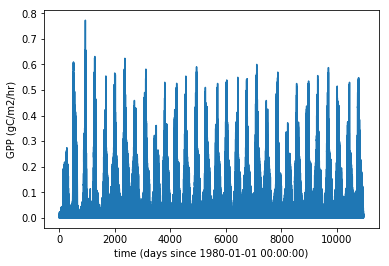

In [43]:
gpp2 = gpp*3600
# Plot output
plt.plot(time,gpp2, label='GPP')
plt.xlabel(''.join(['time (days since ',start_year,' 00:00:00)']))
plt.ylabel('GPP (gC/m2/hr)')

Text(0, 0.5, 'LAI (m2/m2)')

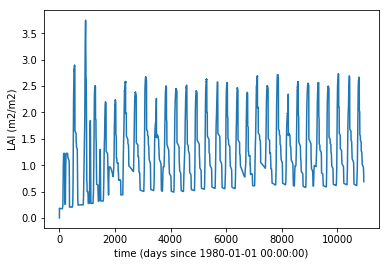

In [19]:
plt.plot(time,lai, label='TLAI')
plt.xlabel(''.join(['time (days since ',start_year,' 00:00:00)']))
plt.ylabel('LAI (m2/m2)')

Text(0.5, 0, 'time (days since 1980-01-01 00:00:00)')

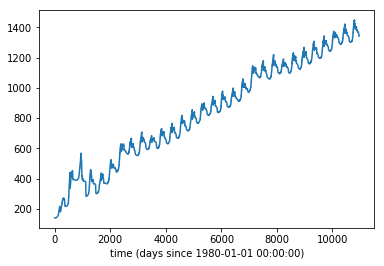

In [95]:
plt.plot(time,totvegc, label='TOTVEGC')
plt.xlabel(''.join(['time (days since ',start_year,' 00:00:00)']))

In [157]:
import netCDF4
import pandas as pd
import numpy as np
ncfile = netCDF4.Dataset(filename_in, 'r')
time = ncfile.variables['time'] # do not cast to numpy array yet 
time_convert = netCDF4.num2date(time[:], time.units, time.calendar)

lai_df = pd.DataFrame(data=lai,index=time_convert)
lai_means = lai_df.groupby(pd.Grouper(freq='1M')).mean()
print(lai_means.head(3))

totvegc_df = pd.DataFrame(data=totvegc,index=time_convert)
#df.groupby(df.index.floor('D')).mean()
totvegc_means = totvegc_df.groupby(pd.Grouper(freq='1M')).mean()
print(totvegc_means.head(3))


                   0
1980-01-31  0.180614
1980-02-29  0.176911
1980-03-31  0.174313
                     0
1980-01-31  140.650482
1980-02-29  141.606033
1980-03-31  144.986008


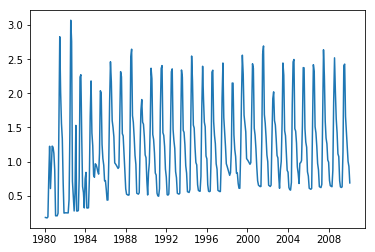

In [158]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot(lai_means, label='Monthly LAI')

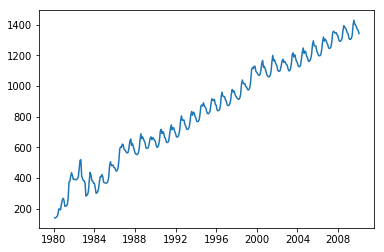

In [159]:
plt.plot(totvegc_means, label='Monthly TOTVEGC')